# Course Theme: Understanding Fastscape Fundementals and Applying Fastscape to Data

# Notebook 2: Fastscape Theory in the Basin

<img src="./02images/awaymountains.jpg" width="500">


### Away from the mountains and into the wild west of the basin...

# Objectives: 
1) Introduce the Sediment Model Equation for Landscape Evolution for basins;
2) discuss implementations in Fastscape 
3) Introduce Basin Steady State
4) Plot an example of Basin Steady-state
5) Discuss additional Parameters helpful for Basin Analysis

## 1) Sediment Model Equation (Erosion+Deposition): G

- Especially in areas of no tectonic uplift (the basin), sediments are deposited to form a piedmont and, ultimately, a sedimentary basin. To model this process, we must add a depositional term to the SPL equation. In FastScape, we have implemented an efficient version of the algorithm developed by Davy and Lague (2009) https://doi.org/10.1029/2008JF001146: $\frac{\partial h}{\partial t} = U - K_f A^mS^n + \frac{G}{A}q_s$ where q_s is the local sedimentary flux and G a dimensionless constant.

- The deposition parameter G can be added to account for the in-channel interaction with an active layer of sediment. This deposition term means that the channel can switch between detachment limited (incision control) vs transport limited (transport and deposition control). The equation tends towards detachment limited (G=0) to transport limited (G>0.4). 

-  Input: Laure Gurie (https://doi.org/10.1130/G46356.1) has done more work better constraining input values of G (range) within the modelling and real world. In the real world, G ∈ [0.4 − 1.2] with a median value of 0.7. Steep rivers and small catchments tend to be associated with low values of G and vice versa (Guerit et al., 2019).

- In Fastscape, use values under 1 within Fastscape. As G increases, your solution becomes more diffusive (erosion rate becoming more proportional to curvature rather than slope). 

- G is also influenced by n. A more linear relationship between slope and erosion would lead to higher values of G but in the same order of magnitude (Guerit et al.,2019). 

- G can also be split into a precipitation component as $Gv^-1$. This means that the precipitation is now inherent in the steady-state equations twice (once from K and once from G) emphasizing that precipitaiton plays a larger role (exponent of 1( from G) and m (from K) in the sediment equation compared to the basic equation. 


## 2) Implementation: Building a Basin in Fastscape


- Fastcsape: uses the algorithm as developed in [Yuan et al, 2019] (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018JF004867) that is $O(n)$ and implicit and is calculated along the drainage stack. It requires, however, an iterative scheme that is rapidly converging but for $G<1$ only. 

- In the sediment model, we can differentiate between values of K and G for bedrock and for sediment.

- Use multiflow for more complex basin drainage patterns

### If you want to have a basin, you need to leave a portion of the model grid space that is not uplifting. 

Thus, we will now be building a raster grid for uplift/subsidence rather than inputing a single value. 

Using a grid space for uplift opens up a range of new possibilities (we won't have time to cover them all):
- You could impose a known/estimated subsidence decay at the foot of a mountain within a raster grid
- You could import a topography raster (DEM) and modify, use it to inform an uplift and subsidence grid rate based on prexisting mountain and basin areas
- You could use a flexure add on to estimate the subsidence in the areas not uplifting with the basin. 

In [5]:
# check how long you need to run a model to reach steady-state

## 3) Basin Steady-State

As described in Braun,2022 (https://doi.org/10.5194/esurf-10-301-2022) :
- Basin steady state is defined as when the change (over time) in the maximum surface elevation of the sedimentary system becomes constant (change in height over time of the fan apex) and the basin profile has reached its steady-state shape (change in slope over time).
- Basin steady state is the response time needed for the system shape to respond to change in its external forcings (incoming sediment flux or precipitation rate). 
- Equations for basin steady state are more complicated than for the orogenic area. Instead, there are three different equations that vary depending on basin length relative to cathcment area and erosion or deposition dominance (see equations 26-28 in Braun, 2022). 




In [141]:
#Summary on the board...(time allowing)

## 4) Basin Evolution: Comparing set-ups

### 4.1) Load and look at two different basin set-ups

In [1]:
import numpy as np
import xarray as xr
import xsimlab as xs
import numba #for wrapping the function
import zarr
import matplotlib.pyplot as plt

%load_ext xsimlab.ipython

In [2]:

BasinB2_25=xr.open_zarr('Flexure20Wide50Prec1_8.zarr').set_index()
startbasin=50

Metadata 

Basin1: 


In [3]:
#Basin B 2.25

In [4]:
#Take a look at basin 1
from ipyfastscape import TopoViz3d

app = TopoViz3d(BasinB2_25, canvas_height=600, time_dim="out")

app.components['background_color'].set_color('lightgray')
app.components['vertical_exaggeration'].set_factor(5)
app.components['timestepper'].go_to_time(BasinB2_25.out[-1])

app.show()

/Users/awild/opt/anaconda3/envs/workshop-itn-potsdam-2023-01/lib/python3.10/site-packages/ipyfastscape/xr_accessor.py:73: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return self._dataset.indexes[self.time_dim].get_loc(time, method='nearest')


Output(layout=Layout(height='640px'))

### 4.2) Excersize: Recall and Calculate Orogenic Steady-State using the model Ouput

In [110]:
# Exercise: Calculate the orogenic stready states for basin 1 and 2
# Don't for get to add .isel(x=slice(0,startbasin)) to select only the mountain area or .isel(x=slice(startbasin, -1)) to select the basin 

######B=2.25
timestepbtw_output=1000 #yrs
SteadystateHeightTHreshold=(1-np.exp(-1))
BasinB2_25_MountainMeanHeight=BasinB2_25.topography__elevation.mean('y').isel(x=slice(0,startbasin)).mean('x')
BasinB2_25_SteadyMountainStartHeight= (BasinB2_25_MountainMeanHeight.max('out').values*SteadystateHeightTHreshold) #Steady state is defined as when the topographic height reaches 63% of the mean topographic maximum over time. 
BasinB2_25_SteadyMountainStart=np.where(BasinB2_25_MountainMeanHeight>=BasinB2_25_SteadyMountainStartHeight)[0][0]
print('Orogenic Steady-State Reached after',BasinB2_25.out[BasinB2_25_SteadyMountainStart].values/1e6, "Myrs")
print('Mean Steady-State Height at',round(float(BasinB2_25.topography__elevation.mean('y').mean('x')[BasinB2_25_SteadyMountainStart].values),2), "m")

######Plot
BasinB2_25.topography__elevation.mean('y').isel(x=slice(0,startbasin)).mean('x').plot()
plt.scatter(BasinB2_25.out[BasinB2_25_SteadyMountainStart],BasinB2_25.topography__elevation.mean('y').isel(x=slice(0,startbasin)).mean('x')[BasinB2_25_SteadyMountainStart],color='b',s=200)



### 4.3) Calculate Basin Steady-State

In [19]:
# Example of Basin Steady-State (import an already run model) and plot it. 

In [ ]:
# calculate basin steady-state?

In [13]:
Cellsize=1000
timestep=1000
firstTimeStepsLimit=5
SteadystateHeightTHreshold=(1-np.exp(-1))
basincelllength=len(BasinB2_25.x.isel(x=slice(startbasin,-1)))

BasinB2_25_BasinSlope=xr.DataArray(((BasinB2_25.topography__elevation.mean('y').isel(x=slice(startbasin,-2))).values-(BasinB2_25.topography__elevation.mean('y').isel(x=slice(startbasin+1,-1))).values)/Cellsize,dims=['time','x'])
BasinB2_25_BasinApex=BasinB2_25.topography__elevation.mean('y').isel(x=slice(startbasin,startbasin+10)).max('x') #Capture the fan apex over time
#
BasinB2_25_SteadyBasinApexStartHeight= (BasinB2_25_BasinApex.max('out').values*SteadystateHeightTHreshold) #Steady state is defined as when the topographic height reaches 63% of the mean topographic maximum over time. 
BasinB2_25_SteadyBasinApexStart=np.where(BasinB2_25_BasinApex>=BasinB2_25_SteadyBasinApexStartHeight)[0][0]

BasinB2_25_MeanSteadySlope_m_m=(BasinB2_25_BasinSlope.isel(x=slice(0,int(basincelllength))).mean('x').isel(time=slice(BasinB2_25_SteadyBasinApexStart,-1)).mean('time').values)
BasinB2_25_MeanSteadySlope_degree=np.arctan(BasinB2_25_MeanSteadySlope_m_m*1000)#input must be in mm/m

print('Basin Slope Steady-State Reached after',BasinB2_25.out[BasinB2_25_SteadyBasinApexStart].values/1e6, "Myrs")
print('Mean Basin Slope Steady-State Slope (degrees)',round(float(BasinB2_25_MeanSteadySlope_degree),3))

Basin Slope Steady-State Reached after 9.8 Myrs
Mean Basin Slope Steady-State Slope (degrees) 1.502


In [93]:
#Basin Steady-State using Fan Apex

Text(0.5, 1.0, 'Basin Fan Apex Height B=2.25')

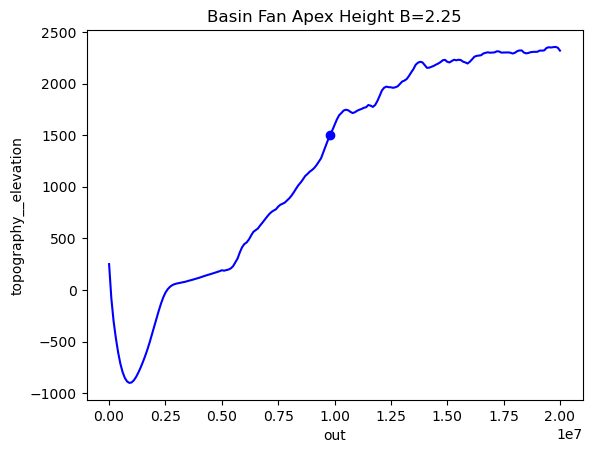

In [144]:

BasinB2_25_BasinApex.plot(color='b')
plt.scatter(BasinB2_25.out[BasinB2_25_SteadyBasinApexStart],BasinB2_25_BasinApex[BasinB2_25_SteadyBasinApexStart],color='b')
plt.gca().set_title('Basin Fan Apex Height B=2.25')

In [146]:
#Basin Steady-State using Slope

Text(0.5, 1.0, 'Basin Fan Slope B=2.25')

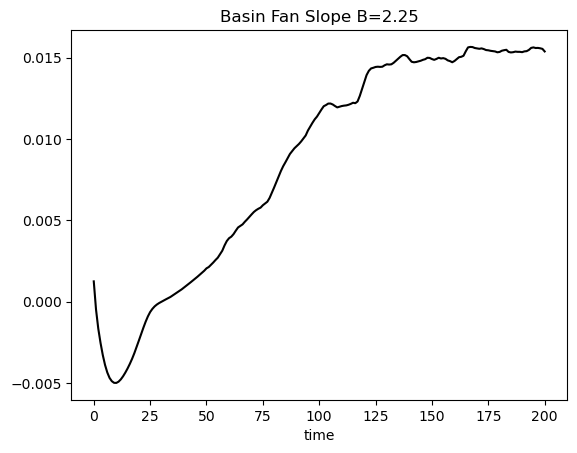

In [14]:
BasinB2_25_BasinSlope.mean('x').plot(color='k')
plt.gca().set_title('Basin Fan Slope B=2.25')

# Compare to other set ups

In [6]:
# Extra: What does the profile look like if you haven't run the model for long enough and it does not reach steady state

<img src="./02images/notsteadystateBasin.png" width="500">

In [20]:
#What does the model look like when steady-state was reached long ago?

<img src="./02images/basin_earlysteady-state.png" width="500">

In [24]:
#BasinB25= xr.open_zarr('Flexure20Wide50Prec20.zarr').set_index()

#Take a look at basin 2
from ipyfastscape import TopoViz3d

app = TopoViz3d(BasinB25, canvas_height=600, time_dim="out")

app.components['background_color'].set_color('lightgray')
app.components['vertical_exaggeration'].set_factor(5)
app.components['timestepper'].go_to_time(BasinB25.out[-1])

app.show()

Cellsize=1000
timestep=1000
firstTimeStepsLimit=5
SteadystateHeightTHreshold=(1-np.exp(-1))
basincelllength=len(BasinB25.x.isel(x=slice(startbasin,-1)))

BasinB25_BasinSlope=xr.DataArray(((BasinB25.topography__elevation.mean('y').isel(x=slice(startbasin,-2))).values-(BasinB25.topography__elevation.mean('y').isel(x=slice(startbasin+1,-1))).values)/Cellsize,dims=['time','x'])
BasinB25_BasinApex=BasinB25.topography__elevation.mean('y').isel(x=slice(startbasin,startbasin+10)).max('x') #Capture the fan apex over time
#
BasinB25_SteadyBasinApexStartHeight= (BasinB25_BasinApex.max('out').values*SteadystateHeightTHreshold) #Steady state is defined as when the topographic height reaches 63% of the mean topographic maximum over time. 
BasinB25_SteadyBasinApexStart=np.where(BasinB25_BasinApex.isel(out=slice(firstTimeStepsLimit,-1))>=BasinB25_SteadyBasinApexStartHeight)[0][0]

BasinB25_MeanSteadySlope_m_m=(BasinB25_BasinSlope.isel(x=slice(0,int(basincelllength))).mean('x').isel(time=slice(BasinB25_SteadyBasinApexStart,-1)).mean('time').values)
BasinB25_MeanSteadySlope_degree=np.arctan(BasinB25_MeanSteadySlope_m_m*1000)#input must be in mm/m

print('Basin Slope Steady-State Reached after',BasinB25.out[BasinB25_SteadyBasinApexStart].values/1e6, "Myrs")
print('Mean Basin Slope Steady-State Slope (degrees)',round(float(BasinB25_MeanSteadySlope_degree),3))

######B=25
timestepbtw_output=1000 #yrs
SteadystateHeightTHreshold=(1-np.exp(-1))
BasinB25_MountainMeanHeight=BasinB25.topography__elevation.mean('y').isel(x=slice(0,startbasin)).mean('x')
BasinB25_SteadyMountainStartHeight= (BasinB25_MountainMeanHeight.max('out').values*SteadystateHeightTHreshold) #Steady state is defined as when the topographic height reaches 63% of the mean topographic maximum over time. 
BasinB25_SteadyMountainStart=np.where(BasinB25_MountainMeanHeight>=BasinB25_SteadyMountainStartHeight)[0][0]
print('Orogenic Steady-State Reached after',BasinB25.out[BasinB25_SteadyMountainStart].values/1e6, "Myrs")
print('Mean Steady-State Height at',round(float(BasinB25.topography__elevation.mean('y').mean('x')[BasinB25_SteadyMountainStart].values),2), "m")

######PLot
BasinB25.topography__elevation.mean('y').isel(x=slice(0,startbasin)).mean('x').plot(color='k')
plt.scatter(BasinB25.out[BasinB25_SteadyMountainStart],BasinB25.topography__elevation.mean('y').isel(x=slice(0,startbasin)).mean('x')[BasinB25_SteadyMountainStart],color='k',s=200)

### 5) Useful Parameters

#### 5.1) Underfill and Bypass

Measuring the underfill and bypass is the ratio of flux to accommodation space. 

- At steady-state, basins can remain in underfill if the imposed accommodation space is much larger than the incoming flux. Thus, the basin may never evolve to be filled. 
- Non-steady-state conditions are often underfilled, but not necessarily. A filled basin will still take time to transition to a new constant height after a external perturbation.

$F = \frac{q_{s,i}}{(1- \gamma_p )L_B \int_0^{1}  \sigma (x') dx'} $

- Underfill and flat topographic solutions are often frequentend by inundation and local minima. Fastscape can simulate this, but the drainage dynamics are totally rerouted (for more information on the rerouting see Cordonnier et al. (2019) (https://doi.org/10.5194/esurf-7-549-2019)). Keep this in mind if you are trying to analyze drainage (or drainage influeced) solutions. 

- Bypass solutions eventually converge to a constant height no matter how much more flux you feed in or how much more you increase F. The F and incoming flux in overfill will control how long it takes to reach a steady-state height however. Underfill solutions (F<1), each increase in F and incoming flux will produce a different max height. 

- Between underfill and high bypass (ex. filled or just over-filled) the basin can still be impacted by local minima


<img src="./02images/ChannelMob_LocalMin.png" width="500">

#### 5.2) Upstream vs Downstream Topographic Control

$\beta=\frac{\nu_ML_M\alpha}{\nu_BL_B}$

<img src="./02images/BetaCHangesAlpha5.png" width="500">

<img src="./02images/NormalizedTopo_BetaCHangesAlpha5.png" width="500">

<img src="./02images/NormalizedTopo_BetaCHangesAlpha2_5.png" width="500">

## 6) General Summary of Basin Evolution

<img src="./02images/BasinF_depo_channelMob.png" width="500">